In [2]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3
import measurement_analysis as ma
import statsmodels.api as sm
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore')

In [3]:
flow_data_DRU, level_data_DRU = lf.get_measurements("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150")
rain_data = lf.get_rain("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf("D:/waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [4]:
def clean_mes_data(df, convert_timestamp=True, sort_timestamp=True, remove_duplicates=True, select_quality=True):
    if convert_timestamp:
        if df["TimeStamp"].dtype != "<M8[ns]":
            df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])

    if sort_timestamp:
        df.sort_values("TimeStamp", inplace=True)
        df.reset_index(drop=True, inplace=True)    

    if remove_duplicates:
        df = df.loc[~df["TimeStamp"].duplicated()].reset_index(drop=True)
    
    if select_quality:
        df = df.loc[df["DataQuality"] == 1].reset_index(drop=True)
    
    return df

def merge_flow_level(flow_data, level_data):
    # INTERPOLATION OF MISSING MEASUREMENTS
    # Get all timestamps
    unique_timestamps = pd.concat([flow_data["TimeStamp"], level_data["TimeStamp"]]).unique()

    # Add timestamps to index
    flow_data = flow_data.set_index("TimeStamp").reindex(unique_timestamps)\
                         .reset_index(drop=False).sort_values("TimeStamp").reset_index(drop=True)
    level_data = level_data.set_index("TimeStamp").reindex(unique_timestamps)\
                           .reset_index(drop=False).sort_values("TimeStamp").reset_index(drop=True)
    
    return flow_data, level_data

def fill_flow(flow_data):
    flow_data["Value"] = flow_data["Value"].fillna(0)
    
    return flow_data

def fill_level(level_data):
    # Fill missing level data
    na_indices = level_data.index[level_data["Value"].isna()]
    non_na_indices = level_data.index[~level_data["Value"].isna()]

    prior_indices = search_prior_indices(na_indices, non_na_indices).reset_index(drop=True)
    posterior_indices = search_posterior_indices(na_indices, non_na_indices).reset_index(drop=True)

    # TimeStamps of prior and posterior indices
    ts_prior = level_data.loc[prior_indices, "TimeStamp"]\
                         .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                         .reset_index(drop=True)
    ts_posterior = level_data.loc[posterior_indices, "TimeStamp"]\
                             .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                             .reset_index(drop=True)
    ts_actual = level_data.loc[level_data["Value"].isna(), "TimeStamp"]\
                          .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                          .reset_index(drop=True)

    # Levels of prior and posterior indices
    level_prior = level_data.loc[prior_indices, "Value"].reset_index(drop=True)
    level_posterior = level_data.loc[posterior_indices, "Value"].reset_index(drop=True)

    # Calculating weighted level values
    fill_values = (level_prior*(ts_posterior-ts_actual) + level_posterior*(ts_actual-ts_prior)) /\
                  (ts_posterior - ts_prior)
    fill_values.index = level_data.index[level_data["Value"].isna()]
    level_data["Value"] = level_data["Value"].fillna(fill_values)
    
    return level_data

In [7]:
def flow_group(flow):
    lst = flow.copy()
    
    not_equal_0 = lst != 0
    after_0 = lst.shift(1) == 0
    not_equal_and_after_0 = not_equal_0 & after_0
    not_equal_and_after_0 = not_equal_and_after_0.cumsum()
    lst.loc[lst != 0] = not_equal_and_after_0.loc[lst != 0]
    return lst.astype(int)


def level_group(lst):
    output = np.repeat(0, len(lst))
    
    maxima = find_peaks(lst, prominence=0.5)[0]
    minima = find_peaks(-lst, prominence=0.5)[0]
    
    min_indices = list(map(lambda i: np.where(minima > i)[0][0], maxima))
    
    for i, j, k in zip(maxima, minima[min_indices], range(len(maxima))):
        output[i:(j+1)] = k+1
    
    return pd.Series(output, index=lst.index)


def search_prior_indices(lst, adjacent_lst):
    prior = []
    
    iter_adjacent_lst = iter(adjacent_lst)

    adj_index = next(iter_adjacent_lst) # current non_na_index
    prior_adj_index = -1
    
    for i in lst:
        if adj_index > i:
            prior += [prior_adj_index]
        else:
            while adj_index < i:
                prior_adj_index = adj_index
                try:
                    adj_index = next(iter_adjacent_lst)
                except:
                    adj_index = i+1

            prior += [prior_adj_index]
    
    return pd.Series(prior, index=lst)


def search_posterior_indices(lst, adjacent_lst):
    posterior = []
    
    iter_adjacent_lst = iter(adjacent_lst)

    adj_index = next(iter_adjacent_lst) # current non_na_index
    posterior_adj_index = -1
    last_index = max(adjacent_lst)
    
    for i in lst:
        if adj_index > i:
            posterior += [adj_index]
        else:
            while adj_index < i:
                try:
                    adj_index = next(iter_adjacent_lst)
                except:
                    adj_index = i+1
            
            if adj_index > last_index:
                adj_index = -1
            posterior += [adj_index]
    
    return pd.Series(posterior, index=lst)


def linearize_circle(p: float):
    r = 0.5
    area = np.pi * r**2

    if p == 0.5:
        return 0.5
    elif p == 1:
        return 1
    elif p == 0:
        return 0
    elif p < 0.5:
        angle = np.arccos((r-p)/r) * 180 / np.pi * 2
        section_area = area * angle / 360
        
        triangle_area = (0.5-p) * np.sqrt(0.5**2-(0.5-p)**2)
        
        return (section_area - triangle_area) / area
    elif p > 0.5:
        return 0.5 + 0.5-linearize_circle(1-p)


class mes_converter:
    def __init__(self, flow_data, level_data):
        # BASIC DATA CLEANING
        flow_data = clean_mes_data(flow_data)
        level_data = clean_mes_data(level_data)
        
        # MATCH TIMESTAMPS OF LEVEL AND FLOW DATA
        flow_data, level_data = merge_flow_level(flow_data, level_data)
        
        # INTERPOLATE MEASUREMENTS
        flow_data = fill_flow(flow_data)
        level_data = fill_level(level_data)
        
        # RENAME VALUE COLUMNS
        flow_data.rename(columns={"Value": "Flow/s"}, inplace=True)
        level_data.rename(columns={"Value": "Level"}, inplace=True)
        flow_data["Flow/s"] = flow_data["Flow/s"] / 3600
        
        # BASIC DATA WRANGLING
        # Get flow/delta per second
        flow_data["TimeSpan"] = flow_data["TimeStamp"].diff(1).apply(lambda i: i.seconds)
        level_data["TimeSpan"] = level_data["TimeStamp"].diff(1).apply(lambda i: i.seconds)
        
        flow_data["Flow"] = flow_data["Flow/s"] * flow_data["TimeSpan"]
        level_data["Delta/s"] = level_data["Level"].diff(1) / level_data["TimeSpan"]
        
        # ADD DATA TO CLASS
        self.flow_data = flow_data
        self.level_data = level_data

    
    def to_dry_data(self, rain_data, area_data, min_dry_series=1, village_code=None, dry_threshold=1):
        self.rain_data = rain_data
        self.area_data = area_data
        
        # CALCULATE WHICH DAYS ARE DRY
        dry_days = ma.summarize_rain_data(self.rain_data, self.area_data,
                                          village_code=village_code,
                                          dry_threshold=dry_threshold)
        
        dry_days = dry_days.loc[dry_days["DrySeries"] >= min_dry_series, "Date"].reset_index(drop=True)
        
        # 
        self.flow_data = self.flow_data.loc[self.flow_data["TimeStamp"]\
                                       .apply(lambda i: i.date() in dry_days.to_list()),:].reset_index(drop=True)
        self.level_data = self.level_data.loc[self.level_data["TimeStamp"]\
                                         .apply(lambda i: i.date() in dry_days.to_list()),:].reset_index(drop=True)
        
        
    def add_groups(self):
        # GROUP FLOW AND LEVEL DATA INTO PHASES
        self.flow_data["group"] = flow_group(self.flow_data["Flow/s"])
        self.level_data["group"] = level_group(self.level_data["Level"])
        
        flow_groups = self.flow_data.sort_values("Flow/s", ascending=False).groupby("group")\
                                    .apply(lambda i: i.iloc[0])[["TimeStamp", "group"]]
        level_groups = self.level_data.sort_values("TimeStamp").groupby("group")\
                                      .apply(lambda i: i.iloc[0])[["TimeStamp", "group"]]
        
        level_groups["Delta"] = self.level_data.groupby("group")["Level"].min() -\
                                self.level_data.groupby("group")["Level"].max()
        level_groups["TimeSpan"] = (self.level_data.groupby("group").apply(lambda i: i.iloc[-1]["TimeStamp"]) -\
                                    self.level_data.groupby("group").apply(lambda i: i.iloc[0]["TimeStamp"]))\
                                   .apply(lambda i: i.total_seconds())
        level_groups["Delta/s"] = level_groups["Delta"] / level_groups["TimeSpan"]
        level_groups["AdjDelta"] = level_groups["Delta"] +\
                (self.level_data.groupby("group")["Level"].max() - self.level_data.groupby("group")["Level"].min().shift(1)) /\
                (self.level_data.groupby("group").apply(lambda i: i.iloc[-1]["TimeStamp"]).shift(1) -\
                 self.level_data.groupby("group").apply(lambda i: i.iloc[0]["TimeStamp"])).apply(lambda i: i.total_seconds())\
                * level_groups["TimeSpan"]
        
        flow_groups["Flow"] = self.flow_data.groupby("group")["Flow"].sum() # Add total flow of peak
        flow_groups["peak_flow"] = self.flow_data.groupby("group")["Flow"].max()
        flow_groups["TimeSpan"] = (self.flow_data.groupby("group").apply(lambda i: i.iloc[-1]["TimeStamp"]) -\
                                   self.flow_data.groupby("group").apply(lambda i: i.iloc[0]["TimeStamp"]))\
                                  .apply(lambda i: i.total_seconds())
        flow_groups = flow_groups.loc[flow_groups["Flow"] > 1]              # Drop missclassified peaks
        flow_groups["level_group"] = flow_groups["TimeStamp"]\
                                    .apply(lambda i: (level_groups["TimeStamp"] - i).abs().idxmin())
                                                                            # ID of level drop
        
        # ADD LEVEL DELTA TO FLOW GROUP
        delta = level_groups.iloc[flow_groups["level_group"]]["Delta"]
        delta.index = flow_groups.index
        flow_groups["Delta"] = delta
        
        # ADD LEVEL DELTA/S TO FLOW GROUP
        delta_p_s = level_groups.iloc[flow_groups["level_group"]]["Delta/s"]
        delta_p_s.index = flow_groups.index
        flow_groups["Delta/s"] = delta_p_s
        
         # ADD LEVEL DELTA/S TO FLOW GROUP
        adj_delta = level_groups.iloc[flow_groups["level_group"]]["AdjDelta"]
        adj_delta.index = flow_groups.index
        flow_groups["AdjDelta"] = adj_delta
        
        # ADD DATA TO CLASS
        self.flow_groups = flow_groups
        self.level_groups = level_groups
    
    
    def get_coefficient(self):
        data = pd.merge(self.flow_data[["TimeStamp", "Flow/s"]],
                        self.level_data[["TimeStamp", "Delta/s", "Level", "group"]], on="TimeStamp", how="inner")
        
        hour_dummies = pd.get_dummies(data["TimeStamp"].apply(lambda i: i.hour), prefix="hour")
        month_dummies = pd.get_dummies(data["TimeStamp"].apply(lambda i: i.month), prefix="month")
        
        y = data["Delta/s"].loc[(data["Flow/s"] == 0) &\
                                (~data["Delta/s"].isna()) &\
                                (data["group"] == 0) &\
                                (data["Delta/s"] > 0)]\
                           .reset_index(drop=True)
        
        X = pd.concat([hour_dummies, month_dummies], axis=1)\
                     .loc[(data["Flow/s"] == 0) &\
                          (~data["Delta/s"].isna()) &\
                          (data["group"] == 0) &\
                          (data["Delta/s"] > 0)]\
                     .reset_index(drop=True)
        
        X = sm.add_constant(X, prepend=False).drop(columns = ["hour_0", "month_1"])
        
        result = sm.OLS(endog = y, exog = X)
        fit_result = result.fit()
        
        intake = fit_result.predict(sm.add_constant(pd.concat([pd.get_dummies(self.level_data["TimeStamp"].apply(lambda i: i.hour), prefix="hour"),
                                                               pd.get_dummies(self.level_data["TimeStamp"].apply(lambda i: i.month), prefix="month")],
                                                              axis=1), prepend=False).drop(columns = ["hour_0", "month_1"]))
        intake[intake < 0] = 0
        self.level_data["intake"] = intake
        self.level_data["AdjDelta/s"] = self.level_data["Delta/s"] - self.level_data["intake"]
        
        self.level_groups["AdjDelta"] = (self.level_data["AdjDelta/s"] * self.level_data["TimeSpan"])\
                                         .groupby(self.level_data["group"]).sum()
        self.level_groups["AdjDelta/s"] = self.level_groups["AdjDelta"] / self.level_groups["TimeSpan"]
        
        # 
        adjdelta = self.level_groups.iloc[self.flow_groups["level_group"]]["AdjDelta"]
        adjdelta.index = self.flow_groups.index
        self.flow_groups["AdjDelta"] = adjdelta
        
        # 
        adjdelta_p_s = self.level_groups.iloc[self.flow_groups["level_group"]]["AdjDelta/s"]
        adjdelta_p_s.index = self.flow_groups.index
        self.flow_groups["AdjDelta/s"] = adjdelta_p_s
        
        self.y = y
        self.X = X
        self.result = result
        
        return result

In [17]:
obj = mes_converter(flow_data_DRU, level_data_DRU)

In [18]:
obj.to_dry_data(rain_data, data.area_data, min_dry_series=2, village_code="DRU", dry_threshold=2.5)

In [19]:
obj.add_groups()

In [11]:
mdl = obj.get_coefficient()

In [604]:
mdl.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Delta/s   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     455.8
Date:                Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:53:57   Log-Likelihood:             1.5194e+06
No. Observations:              277825   AIC:                        -3.039e+06
Df Residuals:                  277790   BIC:                        -3.038e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1        -0.0002   1.34e-05    -14.187      0.000      -0.000      -0.000
hour_2        -0.0003   1.42e-05    -22.225      0.000      -0.000      -0.000
hour_3        -0.0005   1.54e-05    -31.292      0.000      -0.001      -0.000
hour_4        -0.0005   1.59e-05    -30.975      0.000      -0.001      -0.000
hour_5        -0.0006   1.68e-05    -33.563      0.000      -0.001      -0.001
hour_6        -0.0006   1.69e-05    -35.627      0.000      -0.001      -0.001
hour_7        -0.0004   1.52e-05    -23.984      0.000      -0.000      -0.000
hour_8     -5.428e-05   1.35e-05     -4.030      0.000   -8.07e-05   -2.79e-05
hour_9         0.0001   1.28e-05      9.176      0.000    9.23e-05       0.000
hour_10        0.0002   1.25e-05     17.291      0.000       0.000       0.000
hour_11        0.0003   1.25e-05     21.669      0.000       0.000       0.000
hour_12        0.0003   1.25e-05     21.014      0.000       0.000       0.000
hour_13        0.0002   1.26e-05     17.931      0.000       0.000       0.000
hour_14        0.0001   1.27e-05     11.265      0.000       0.000       0.000
hour_15     6.126e-05   1.28e-05      4.787      0.000    3.62e-05    8.63e-05
hour_16     3.444e-05   1.29e-05      2.679      0.007    9.25e-06    5.96e-05
hour_17    -6.027e-06   1.29e-05     -0.466      0.641   -3.14e-05    1.93e-05
hour_18     5.416e-05   1.28e-05      4.239      0.000    2.91e-05    7.92e-05
hour_19        0.0002   1.26e-05     14.070      0.000       0.000       0.000
hour_20        0.0003   1.24e-05     21.883      0.000       0.000       0.000
hour_21        0.0003   1.24e-05     21.226      0.000       0.000       0.000
hour_22        0.0002   1.26e-05     13.167      0.000       0.000       0.000
hour_23        0.0001   1.27e-05      8.185      0.000    7.89e-05       0.000
month_2    -8.852e-05   8.98e-06     -9.857      0.000      -0.000   -7.09e-05
month_3     9.995e-06    9.9e-06      1.009      0.313   -9.42e-06    2.94e-05
month_4    -4.036e-05   9.31e-06     -4.336      0.000   -5.86e-05   -2.21e-05
month_5       -0.0001   9.42e-06    -14.095      0.000      -0.000      -0.000
month_6    -6.149e-05   8.86e-06     -6.940      0.000   -7.89e-05   -4.41e-05
month_7       -0.0002    9.3e-06    -23.444      0.000      -0.000      -0.000
month_8    -4.977e-05   1.08e-05     -4.620      0.000   -7.09e-05   -2.87e-05
month_9       -0.0001   9.95e-06    -12.561      0.000      -0.000      -0.000
month_10      -0.0001   1.08e-05    -10.154      0.000      -0.000   -8.88e-05
month_11   -5.608e-05   9.08e-06     -6.180      0.000   -7.39e-05   -3.83e-05
month_12   -1.974e-05   9.86e-06     -2.001      0.045   -3.91e-05   -4.02e-07
const          0.0013   1.12e-05    112.948      0.000       0.001       0.001
==============================================================================
Om

In [221]:
delta = level_groups.iloc[flow_groups["level_group"]]["Delta"]
delta.index = flow_groups.index
flow_groups["Delta"] = delta

C:\Users\sdannehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


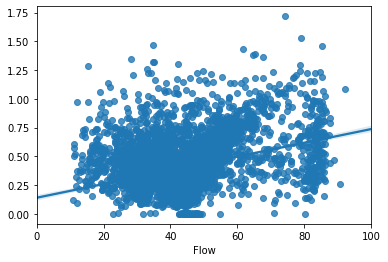

In [25]:
#plt.ylim(-1,-3)
plt.xlim(0,100)
sns.regplot(y["Flow"], y["Delta"]-y["AdjDelta"])

In [24]:
y = x.loc[~x["level_group"].duplicated()]

In [26]:
np.corrcoef(y["Flow"], y["Delta"]-y["AdjDelta"])

array([[1.        , 0.31891141],
       [0.31891141, 1.        ]])

In [23]:
x = obj.flow_groups.loc[obj.flow_groups["Flow"].between(10, 100) &
                        obj.flow_groups["TimeSpan"].between(150,750) &
                        obj.flow_groups["Delta"].between(-1.5,-1) &
                        obj.flow_groups["AdjDelta"].between(-3, -1)]#.groupby("level_group")[["TimeSpan", "Delta/s"]].aggregate({"TimeSpan": "sum", "Delta/s": "mean"})

In [552]:
obj.flow_groups["Flow"].sort_values().median()

45.25540523291668

In [444]:
obj.level_data["intake"].min()

-0.0019678323825012686

In [636]:
pd.merge(obj.level_data[["TimeStamp", "Level", "DataQuality", "group"]],
         obj.flow_data[["TimeStamp", "Flow/s", "DataQuality", "group"]], on="TimeStamp", how="inner").to_csv("visualize.csv")

In [637]:
pd.merge(obj.level_data[["TimeStamp", "Level", "DataQuality", "group"]],
         obj.flow_data[["TimeStamp", "Flow/s", "DataQuality", "group"]], on="TimeStamp", how="inner")

,TimeStamp,Level,DataQuality_x,group_x,Flow/s,DataQuality_y,group_y
0,2018-01-08 00:00:55,-0.389881,1.0,0,0.000000,NaN,0
1,2018-01-08 00:03:10,-0.338424,1.0,0,0.000000,NaN,0
2,2018-01-08 00:05:30,-0.287297,1.0,0,0.000000,NaN,0
3,2018-01-08 00:08:20,-0.236335,1.0,0,0.000000,NaN,0
4,2018-01-08 00:10:35,-0.269265,NaN,0,0.000096,1.0,1
5,2018-01-08 00:10:40,-0.270485,NaN,0,0.002692,1.0,1
6,2018-01-08 00:10:45,-0.271705,NaN,0,0.013803,1.0,1
7,2018-01-08 00:10:50,-0.272924,NaN,0,0.022136,1.0,1
8,2018-01-08 00:10:55,-0.274144,NaN,0,0.030470,1.0,1
9,2018-01-08 00:11:00,-0.275363,NaN,0,0.041581,1.0,1


In [667]:
obj.flow_groups.loc[obj.flow_groups["level_group"].between(7127,7153)]

,TimeStamp,group,Flow,peak_flow,TimeSpan,level_group,Delta,Delta/s,AdjDelta,AdjDelta/s
group,,,,,,,,,,
18238,2018-11-11 00:18:20,18238,43.879932,0.907029,415.0,7127,-1.325678,-0.002389,-2.114752,-0.003810
18239,2018-11-11 01:04:45,18239,43.613902,0.898076,415.0,7128,-1.330937,-0.002398,-2.050577,-0.003695
18240,2018-11-11 01:57:05,18240,34.083648,0.896330,255.0,7129,-1.545191,-0.003512,-2.195834,-0.004991
18241,2018-11-11 01:59:40,18241,9.137886,0.709663,155.0,7129,-1.545191,-0.003512,-2.195834,-0.004991
18243,2018-11-11 03:11:35,18243,42.181253,0.908662,400.0,7130,-1.373830,-0.002114,-1.933365,-0.002974
18244,2018-11-11 03:50:00,18244,44.146607,0.903997,415.0,7131,-1.281309,-0.003087,-1.626944,-0.003920
18246,2018-11-11 05:06:15,18246,42.537613,0.900232,435.0,7132,-1.528207,-0.001934,-2.114703,-0.002677
18248,2018-11-11 07:14:15,18248,41.889352,0.906659,505.0,7133,-1.421331,-0.002584,-2.290031,-0.004164
18249,2018-11-11 08:14:15,18249,46.939470,0.873723,435.0,7134,-1.183984,-0.002923,-1.720075,-0.004247


In [644]:
inv = obj.flow_groups.loc[18238:18271]

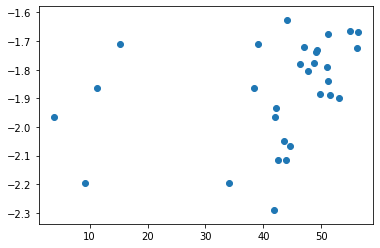

In [656]:
#plt.ylim(-0.00525,-0.0035)
plt.scatter(inv["Flow"], inv["AdjDelta"])

In [179]:
flow_groups["TimeStamp"] = flow_groups["TimeStamp"].apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())
level_groups["TimeStamp"] = level_groups["TimeStamp"].apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())

In [195]:
flow_groups["Flow"] = obj.flow_data.groupby("group")["Flow"].sum()
flow_groups = flow_groups.loc[flow_groups["Flow"] > 1]
#level_groups["Delta"] = obj.flow_data.groupby("group")["Flow"].sum()

In [201]:
level_groups["Delta"] = obj.level_data.groupby("group")["Level"].max() - obj.level_data.groupby("group")["Level"].min()

In [198]:
flow_groups["level_group"] = flow_groups["TimeStamp"].apply(lambda i: (level_groups["TimeStamp"] - i).abs().idxmin())

C:\Users\sdannehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [191]:
pd.concat([obj.flow_data, obj.level_data], axis=1).to_csv("visualize_now.csv")

In [186]:
abs(level_groups["TimeStamp"] - flow_groups["TimeStamp"][10]).idxmin()

5

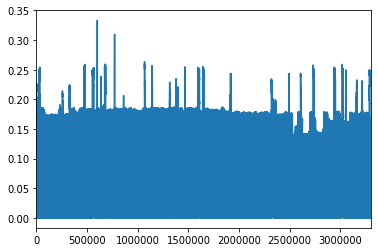

In [174]:
obj.flow_data["Flow/s"].plot()

In [70]:
# Try to get the actual coefficient
hour_dummies = pd.get_dummies(obj.level_data["TimeStamp"].apply(lambda i: i.hour), prefix="hour")
month_dummies = pd.get_dummies(obj.level_data["TimeStamp"].apply(lambda i: i.month), prefix="month")
ml_data = pd.concat([obj.level_data["Level"], obj.level_data["Level"]**2, hour_dummies, month_dummies], axis=1).drop(columns = ["hour_0", "month_1"])
ml_data = sm.add_constant(ml_data, prepend=False)

C:\Users\sdannehl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [72]:
predicted = mdl.fit().predict(ml_data)

In [81]:
diff = obj.level_data["Delta/s"] - predicted
flow = obj.flow_data["Flow/s"]

In [19]:
x = flow_group(obj.flow_data["Flow/s"])

In [30]:
obj.level_data["Level"].tail(30)

3305008   -1.435411
3305009   -1.439060
3305010   -1.442710
3305011   -1.446359
3305012   -1.398915
3305013   -1.351223
3305014   -1.355992
3305015   -1.360762
3305016   -1.365531
3305017   -1.370300
3305018   -1.375069
3305019   -1.379838
3305020   -1.384607
3305021   -1.389377
3305022   -1.394146
3305023   -1.346454
3305024   -1.306664
3305025   -1.326559
3305026   -1.286769
3305027   -1.246196
3305028   -1.225910
3305029   -1.168185
3305030   -1.113775
3305031   -1.049602
3305032   -0.990050
3305033   -0.934137
3305034   -0.881196
3305035   -0.829904
3305036   -0.775480
3305037   -0.724351
Name: Level, dtype: float64

In [41]:
obj.flow_data.reset_index(drop=False).sort_values("Flow/s").groupby(x).apply(lambda group: group.iloc[0])

,index,TimeStamp,RG_ID,Flow/s,DataQuality,TimeSpan
Flow/s,,,,,,
0,0,2018-01-01 00:00:05,8150.0,0.0,1.0,NaN
1,10578,2018-01-01 15:09:25,8150.0,1.0,1.0,5.0
2,10592,2018-01-01 15:10:45,8150.0,2.0,1.0,5.0
3,10630,2018-01-01 15:16:25,8150.0,3.0,1.0,5.0
4,10743,2018-01-01 15:26:25,8150.0,4.0,1.0,5.0
5,10747,2018-01-01 15:27:15,8150.0,5.0,1.0,5.0
6,10809,2018-01-01 15:35:45,8150.0,6.0,1.0,5.0
7,10847,2018-01-01 15:39:00,8150.0,7.0,1.0,5.0
8,10975,2018-01-01 15:56:40,8150.0,8.0,1.0,5.0


In [607]:
fit_mdl = mdl.fit()

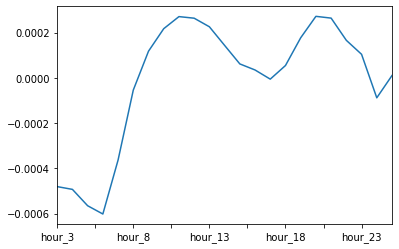

In [608]:
(fit_mdl.params[2:25]).plot()

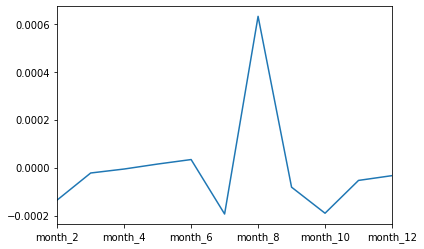

In [431]:
fit_mdl.params[25:36].plot()

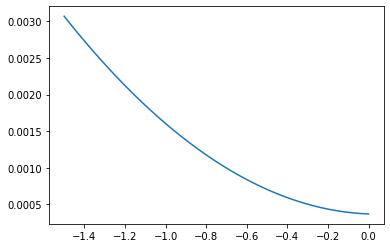

In [432]:
plt.plot(pd.Series(np.linspace(-1.5,0,100)),
         pd.Series(np.linspace(-1.5,0,100) * fit_mdl.params[0] + np.linspace(-1.5,0,100)**2 * fit_mdl.params[1]) + fit_mdl.params[-1])

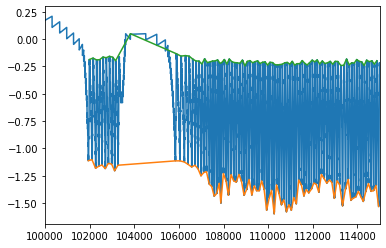

In [102]:
#find_peaks(obj.level_data["Level"].iloc[0:3000])

fig, ax = plt.subplots()
obj.level_data["Level"].iloc[100000:115000].plot(ax=ax)

obj.level_data.loc[find_peaks(-obj.level_data["Level"].iloc[100000:115000], prominence=0.5)[0] + 100000, "Level"].plot(ax=ax)
obj.level_data.loc[find_peaks(obj.level_data["Level"].iloc[100000:115000], prominence=0.5)[0] + 100000, "Level"].plot(ax=ax)

In [146]:
def level_group(lst):
    output = np.repeat(0, len(lst))
    
    maxima = find_peaks(lst, prominence=0.5)[0]
    minima = find_peaks(-lst, prominence=0.5)[0]
    
    min_indices = list(map(lambda i: np.where(minima > i)[0][0], maxima))
    
    for i, j, k in zip(maxima, minima[min_indices], range(len(maxima))):
        output[i:(j+1)] = k+1
    
    return pd.Series(output, index=lst.index)

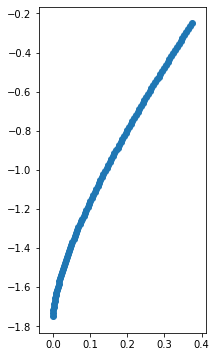

In [218]:
plt.figure(figsize=(3,6))
plt.scatter(np.array(lst), np.linspace(0,1,100)*0.4*3.75-1.75)